In [1]:
import sys
sys.path.append('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders')


from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from scipy import interpolate
import ot

import jmp_solver1.surrogates

In [2]:
device

device(type='cpu')

In [3]:
# Get RK coefficients for these images and also the images

In [4]:

trainImages = torch.load('/home/ramana44/oasis_mri_2d_slices_hybridAlphaHalf_81coeffs_RK_LossWithImage/savedDatasetAndCoeffs/trainDataSet.pt',map_location=torch.device('cpu'))
trainCoeffs = torch.load('/home/ramana44/oasis_mri_2d_slices_hybridAlphaHalf_81coeffs_RK_LossWithImage/savedDatasetAndCoeffs/trainDataRK_coeffs.pt',map_location=torch.device('cpu'))


testImages = torch.load('/home/ramana44/oasis_mri_2d_slices_hybridAlphaHalf_81coeffs_RK_LossWithImage/savedDatasetAndCoeffs/testDataSet.pt',map_location=torch.device('cpu'))
testCoeffs = torch.load('/home/ramana44/oasis_mri_2d_slices_hybridAlphaHalf_81coeffs_RK_LossWithImage/savedDatasetAndCoeffs/testDataRK_coeffs.pt',map_location=torch.device('cpu'))

In [5]:
Analys_size = 200

In [6]:
trainImages = trainImages[:Analys_size]
trainCoeffs = trainCoeffs[:Analys_size]

testImages = testImages[:Analys_size]
testCoeffs = testCoeffs[:Analys_size]

In [7]:
trainCoeffs.shape

torch.Size([200, 6561])

In [8]:
# load trained rAE and bAE
from models import AE
from activations import Sin

path = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/output/MRT_full/test_run_saving/'
#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.01
frac = 0.8
hidden_size = 1000
deg_poly = 20
latent_dim = 18
lr = 0.0001
no_layers = 5
#no_epochs=?
name = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)

#no_channels, dx, dy = (train_loader_alz.dataset.__getitem__(1).shape)
#inp_dim = [no_channels, dx-21, dy-21]
inp_dim = 81*81

model_reg = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)
model_base = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path+'model_base'+name, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

<All keys matched successfully>

In [9]:
type(trainCoeffs)

torch.Tensor

In [10]:
#trainCoeffs = trainCoeffs + 0.0001 * torch.rand(trainCoeffs.shape)

In [11]:
rec_rAE_train = model_reg(trainCoeffs.float()).view(trainCoeffs.shape)
rec_bAE_train = model_base(trainCoeffs.float()).view(trainCoeffs.shape)

rec_rAE_test = model_reg(testCoeffs.float()).view(testCoeffs.shape)
rec_bAE_test = model_base(testCoeffs.float()).view(testCoeffs.shape)

In [12]:
rec_rAE_train = torch.tensor(rec_rAE_train, requires_grad=False)
rec_bAE_train = torch.tensor(rec_bAE_train, requires_grad=False)

rec_rAE_test = torch.tensor(rec_rAE_test, requires_grad=False)
rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)

/tmp/ipykernel_36323/1395426734.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_train = torch.tensor(rec_rAE_train, requires_grad=False)
/tmp/ipykernel_36323/1395426734.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_train = torch.tensor(rec_bAE_train, requires_grad=False)
/tmp/ipykernel_36323/1395426734.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_test = torch.tensor(rec_rAE_test, requires_grad=False)
/tmp/ipykernel_36323/1395426734.py:5: UserWarning: To copy construct from a tensor, it is recommend

In [13]:
deg_quad = 80
u_ob = jmp_solver1.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
x = np.linspace(-1,1,96)
X_p = u_ob.data_axes([x,x]).T

In [14]:
reconReg_train = torch.matmul(X_p.float(), rec_rAE_train.squeeze(1).T).T

reconBase_train = torch.matmul(X_p.float(), rec_bAE_train.squeeze(1).T).T

reconReg_test = torch.matmul(X_p.float(), rec_rAE_test.squeeze(1).T).T

reconBase_test = torch.matmul(X_p.float(), rec_bAE_test.squeeze(1).T).T

In [15]:
imageOfPerturbedCoeffsBeforeAE = torch.matmul(X_p.float(), trainCoeffs.float().squeeze(1).T).T

In [16]:
imageOfPerturbedCoeffsBeforeAE.shape

torch.Size([200, 9216])

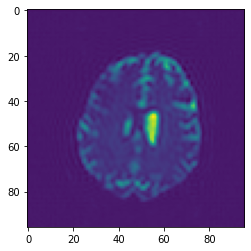

In [17]:
plt.imshow(imageOfPerturbedCoeffsBeforeAE[0].reshape(96,96))

In [18]:
reconReg_train = reconReg_train.reshape(Analys_size,1,96,96)
reconBase_train = reconBase_train.reshape(Analys_size,1,96,96)

reconReg_test = reconReg_test.reshape(Analys_size,1,96,96)
reconBase_test = reconBase_test.reshape(Analys_size,1,96,96)

In [19]:
# PSNR and SSIM calculations


# function of batch psnr
def batch_psnr(batch_prediction, batch_target):
    avg_psnr = 0
    for i in range(batch_prediction.size(0)):
        mse = F.mse_loss(batch_prediction[i], batch_target[i])
        if mse > 0.:
            psnr = 10 * torch.log10(1 / mse)
            avg_psnr += psnr
        else:
            avg_psnr += 100.

    return (avg_psnr / batch_prediction.size(0)).item()

In [20]:
#PSNR for train dataset

psnr_rAE_train = batch_psnr(reconReg_train.reshape(trainImages[:500].shape), trainImages[:500])
psnr_bAE_train = batch_psnr(reconBase_train.reshape(trainImages[:500].shape), trainImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_train, psnr_bAE_train))

PSNR rAE: 29.76, bAE: 29.76


In [21]:
#PSNR for test dataset

psnr_rAE_test = batch_psnr(reconReg_test.reshape(testImages[:500].shape), testImages[:500])
psnr_bAE_test = batch_psnr(reconBase_test.reshape(testImages[:500].shape), testImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_test, psnr_bAE_test))

PSNR rAE: 29.89, bAE: 29.90


In [22]:
reconReg_train.shape

torch.Size([200, 1, 96, 96])

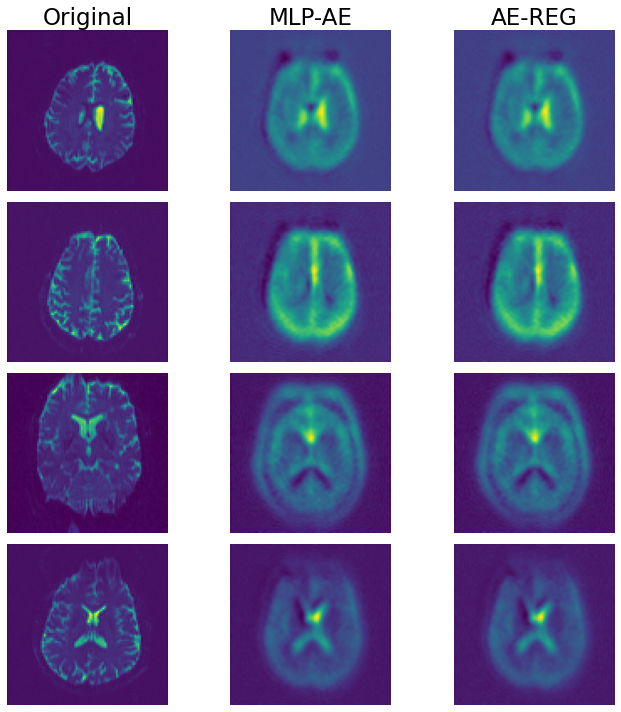

In [23]:
# PLotting trained images reconstructed

fig, axes = plt.subplots(4, 3, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3 = axes[i]
    ax1.imshow(trainImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(reconBase_train[i][0])
    if(i==0):
        ax2.set_title('MLP-AE', fontsize = 23)
    ax3.imshow(reconReg_train[i][0])
    if(i==0):
        ax3.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

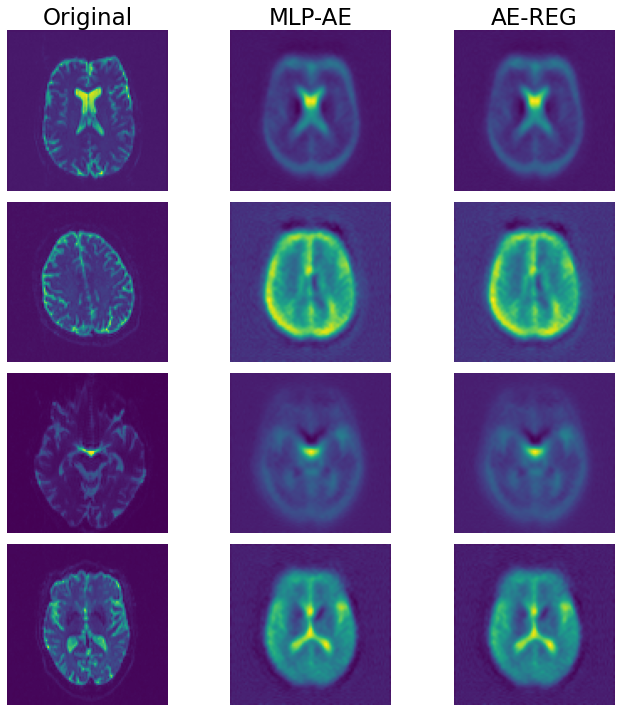

In [24]:
# PLotting test images reconstructed

fig, axes = plt.subplots(4, 3, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3 = axes[i]
    ax1.imshow(testImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(reconBase_test[i][0])
    if(i==0):
        ax2.set_title('MLP-AE', fontsize = 23)
    ax3.imshow(reconReg_test[i][0])
    if(i==0):
        ax3.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

In [25]:
# add some noise to the train images, get RK coefficients and check reconstructions and PSNR

trainImages_perturbed =trainImages + 2 * 1e-1 *  torch.rand(trainImages.shape)

testImages_perturbed =testImages + 2 * 1e-1 *  torch.rand(testImages.shape)

In [26]:
trainImages_perturbed.shape

torch.Size([200, 1, 96, 96])

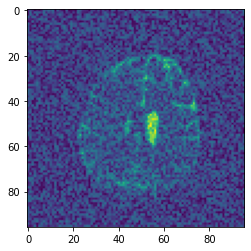

In [27]:
plt.imshow(trainImages_perturbed[0][0])

In [28]:
#corresponding coefficients of these noised images

coeffsOftrainImages_perturbed = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/trainCoeff_noise_0_to_200.pt')

coeffsOftestImages_perturbed = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/testCoeff_noise_50_to_50200.pt')

In [29]:
coeffsOftestImages_perturbed.shape

torch.Size([200, 6561])

In [30]:
#now do reconstruction of coefficients of perturbed images

rec_rAE_train_perturbed = model_reg(coeffsOftrainImages_perturbed.float()).view(coeffsOftrainImages_perturbed.shape)
rec_bAE_train_perturbed = model_base(coeffsOftrainImages_perturbed.float()).view(coeffsOftrainImages_perturbed.shape)

rec_rAE_test_perturbed = model_reg(coeffsOftestImages_perturbed.float()).view(coeffsOftestImages_perturbed.shape)
rec_bAE_test_perturbed = model_base(coeffsOftestImages_perturbed.float()).view(coeffsOftestImages_perturbed.shape)


In [31]:
rec_rAE_train_perturbed = torch.tensor(rec_rAE_train_perturbed, requires_grad=False)
rec_bAE_train_perturbed = torch.tensor(rec_bAE_train_perturbed, requires_grad=False)

rec_rAE_test_perturbed = torch.tensor(rec_rAE_test_perturbed, requires_grad=False)
rec_bAE_test_perturbed = torch.tensor(rec_bAE_test_perturbed, requires_grad=False)

/tmp/ipykernel_36323/1877534959.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_train_perturbed = torch.tensor(rec_rAE_train_perturbed, requires_grad=False)
/tmp/ipykernel_36323/1877534959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_train_perturbed = torch.tensor(rec_bAE_train_perturbed, requires_grad=False)
/tmp/ipykernel_36323/1877534959.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_test_perturbed = torch.tensor(rec_rAE_test_perturbed, requires_grad=False)
/tmp/ipykernel_36323/1877534959.py:5: U

In [32]:
reconReg_train_perturbed = torch.matmul(X_p.float(), rec_rAE_train_perturbed.squeeze(1).T).T

reconBase_train_perturbed = torch.matmul(X_p.float(), rec_bAE_train_perturbed.squeeze(1).T).T

reconReg_test_perturbed = torch.matmul(X_p.float(), rec_rAE_test_perturbed.squeeze(1).T).T

reconBase_test_perturbed = torch.matmul(X_p.float(), rec_bAE_test_perturbed.squeeze(1).T).T

In [33]:
reconReg_train_perturbed = reconReg_train_perturbed.reshape(Analys_size,1,96,96)
reconBase_train_perturbed = reconBase_train_perturbed.reshape(Analys_size,1,96,96)

reconReg_test_perturbed = reconReg_test_perturbed.reshape(Analys_size,1,96,96)
reconBase_test_perturbed = reconBase_test_perturbed.reshape(Analys_size,1,96,96)

In [34]:
#PSNR for images perturbed in train dataset

psnr_rAE_train_perturbed = batch_psnr(reconReg_train_perturbed.reshape(trainImages[:500].shape), trainImages[:500])
psnr_bAE_train_perturbed = batch_psnr(reconBase_train_perturbed.reshape(trainImages[:500].shape), trainImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_train_perturbed, psnr_bAE_train_perturbed))

PSNR rAE: 27.34, bAE: 27.69


In [35]:
#PSNR for images perturbed in test dataset

psnr_rAE_test_perturbed = batch_psnr(reconReg_test_perturbed.reshape(testImages[:500].shape), testImages[:500])
psnr_bAE_test_perturbed = batch_psnr(reconBase_test_perturbed.reshape(testImages[:500].shape), testImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_test_perturbed, psnr_bAE_test_perturbed))

PSNR rAE: 27.44, bAE: 27.80


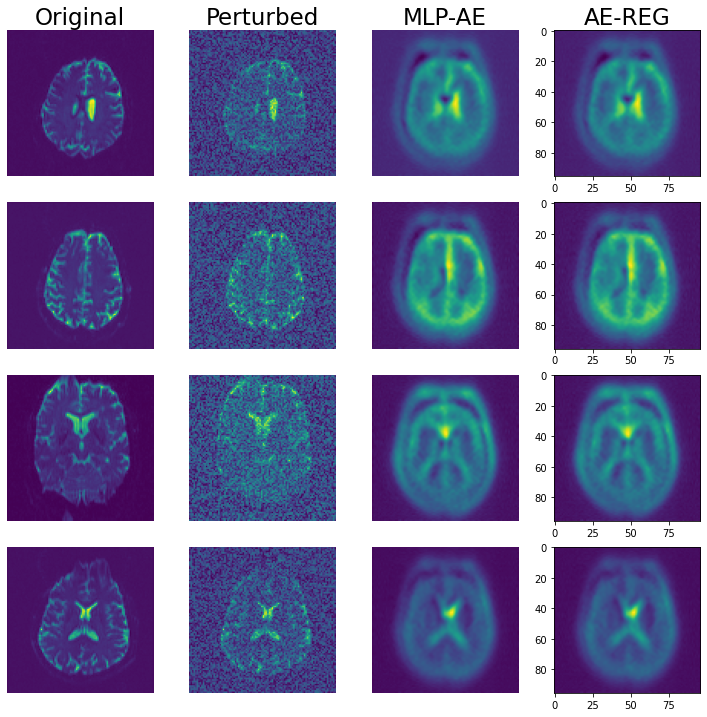

In [36]:
# PLotting perturbed train images reconstructed

fig, axes = plt.subplots(4, 4, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.imshow(trainImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(trainImages_perturbed[i][0])
    if(i==0):
        ax2.set_title('Perturbed', fontsize = 23)
    ax3.imshow(reconBase_train_perturbed[i][0])
    if(i==0):
        ax3.set_title('MLP-AE', fontsize = 23)
    ax4.imshow(reconReg_train_perturbed[i][0])
    if(i==0):
        ax4.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

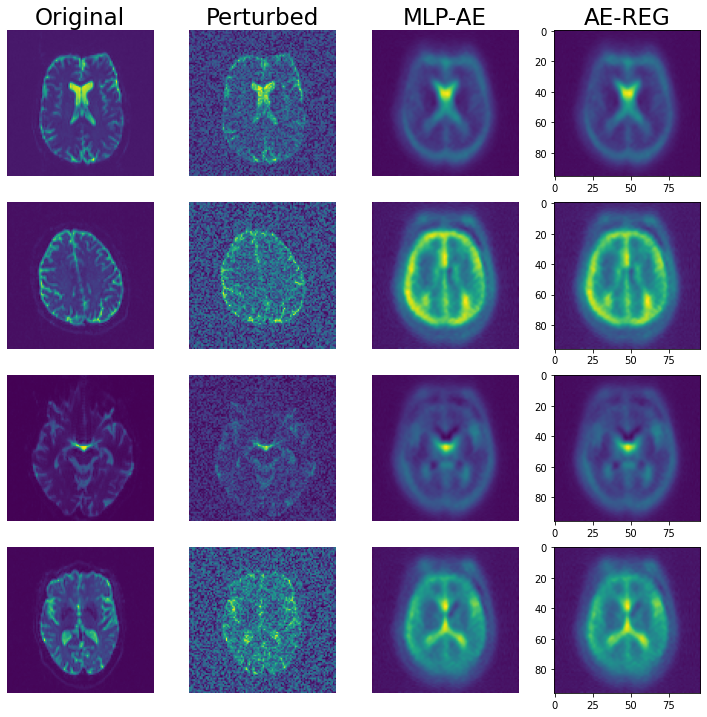

In [37]:
# PLotting perturbed test images reconstructed

fig, axes = plt.subplots(4, 4, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.imshow(testImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(testImages_perturbed[i][0])
    if(i==0):
        ax2.set_title('Perturbed', fontsize = 23)
    ax3.imshow(reconBase_test_perturbed[i][0])
    if(i==0):
        ax3.set_title('MLP-AE', fontsize = 23)
    ax4.imshow(reconReg_test_perturbed[i][0])
    if(i==0):
        ax4.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

In [38]:
# Now perturnb directly the coefficients and see

trainCoeffs_pert = trainCoeffs + 1 * 1e-3 * torch.rand(trainCoeffs.shape)

testCoeffs_pert = testCoeffs +  1 * 1e-3 * torch.rand(testCoeffs.shape)

In [39]:
trainCoeffs_pert.shape

torch.Size([200, 6561])

In [40]:
ImagesFromPerturbedTrainCoeffs = torch.matmul(X_p.float(), trainCoeffs_pert.float().squeeze(1).T).T

ImagesFromPerturbedTestCoeffs = torch.matmul(X_p.float(), testCoeffs_pert.float().squeeze(1).T).T


ImagesFromPerturbedTrainCoeffs = ImagesFromPerturbedTrainCoeffs.reshape(Analys_size,1,96,96)
ImagesFromPerturbedTestCoeffs = ImagesFromPerturbedTestCoeffs.reshape(Analys_size,1,96,96)

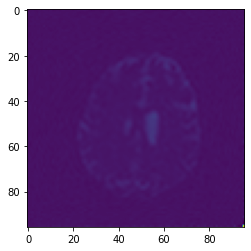

In [41]:
plt.imshow(ImagesFromPerturbedTrainCoeffs[0].reshape(96,96))

In [42]:
#now do reconstruction of perturbed coefficients

rec_rAE_train_perturbedCoeffs = model_reg(trainCoeffs_pert.float()).view(trainCoeffs_pert.shape)
rec_bAE_train_perturbedCoeffs = model_base(trainCoeffs_pert.float()).view(trainCoeffs_pert.shape)

rec_rAE_test_perturbedCoeffs = model_reg(testCoeffs_pert.float()).view(testCoeffs_pert.shape)
rec_bAE_test_perturbedCoeffs = model_base(testCoeffs_pert.float()).view(testCoeffs_pert.shape)


In [43]:
rec_rAE_train_perturbedCoeffs = torch.tensor(rec_rAE_train_perturbedCoeffs, requires_grad=False)
rec_bAE_train_perturbedCoeffs = torch.tensor(rec_bAE_train_perturbedCoeffs, requires_grad=False)

rec_rAE_test_perturbedCoeffs = torch.tensor(rec_rAE_test_perturbedCoeffs, requires_grad=False)
rec_bAE_test_perturbedCoeffs = torch.tensor(rec_bAE_test_perturbedCoeffs, requires_grad=False)

/tmp/ipykernel_36323/2079514035.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_train_perturbedCoeffs = torch.tensor(rec_rAE_train_perturbedCoeffs, requires_grad=False)
/tmp/ipykernel_36323/2079514035.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_train_perturbedCoeffs = torch.tensor(rec_bAE_train_perturbedCoeffs, requires_grad=False)
/tmp/ipykernel_36323/2079514035.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_test_perturbedCoeffs = torch.tensor(rec_rAE_test_perturbedCoeffs, requires_grad=False)
/tm

In [44]:
reconReg_train_perturbedCoeffs = torch.matmul(X_p.float(), rec_rAE_train_perturbedCoeffs.squeeze(1).T).T

reconBase_train_perturbedCoeffs = torch.matmul(X_p.float(), rec_bAE_train_perturbedCoeffs.squeeze(1).T).T

reconReg_test_perturbedCoeffs = torch.matmul(X_p.float(), rec_rAE_test_perturbedCoeffs.squeeze(1).T).T

reconBase_test_perturbedCoeffs = torch.matmul(X_p.float(), rec_bAE_test_perturbedCoeffs.squeeze(1).T).T

In [45]:
reconReg_train_perturbedCoeffs = reconReg_train_perturbedCoeffs.reshape(Analys_size,1,96,96)
reconBase_train_perturbedCoeffs = reconBase_train_perturbedCoeffs.reshape(Analys_size,1,96,96)

reconReg_test_perturbedCoeffs = reconReg_test_perturbedCoeffs.reshape(Analys_size,1,96,96)
reconBase_test_perturbedCoeffs = reconBase_test_perturbedCoeffs.reshape(Analys_size,1,96,96)

In [46]:
reconReg_train_perturbedCoeffs = reconReg_train_perturbedCoeffs.reshape(Analys_size,1,96,96)
reconBase_train_perturbedCoeffs = reconBase_train_perturbedCoeffs.reshape(Analys_size,1,96,96)

reconReg_test_perturbedCoeffs = reconReg_test_perturbedCoeffs.reshape(Analys_size,1,96,96)
reconBase_test_perturbedCoeffs = reconBase_test_perturbedCoeffs.reshape(Analys_size,1,96,96)

In [47]:
#PSNR for Images from perturbedcoeffs in train dataset

psnr_rAE_train_perturbedCoeffs = batch_psnr(reconReg_train_perturbedCoeffs.reshape(trainImages[:500].shape), trainImages[:500])
psnr_bAE_train_perturbedCoeffs = batch_psnr(reconBase_train_perturbedCoeffs.reshape(trainImages[:500].shape), trainImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_train_perturbedCoeffs, psnr_bAE_train_perturbedCoeffs))

PSNR rAE: 29.74, bAE: 29.69


In [48]:
#PSNR for Images from perturbedcoeffs in train dataset

psnr_rAE_test_perturbedCoeffs = batch_psnr(reconReg_test_perturbedCoeffs.reshape(testImages[:500].shape), testImages[:500])
psnr_bAE_test_perturbedCoeffs = batch_psnr(reconBase_test_perturbedCoeffs.reshape(testImages[:500].shape), testImages[:500])
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE_test_perturbedCoeffs, psnr_bAE_test_perturbedCoeffs))

PSNR rAE: 29.87, bAE: 29.82


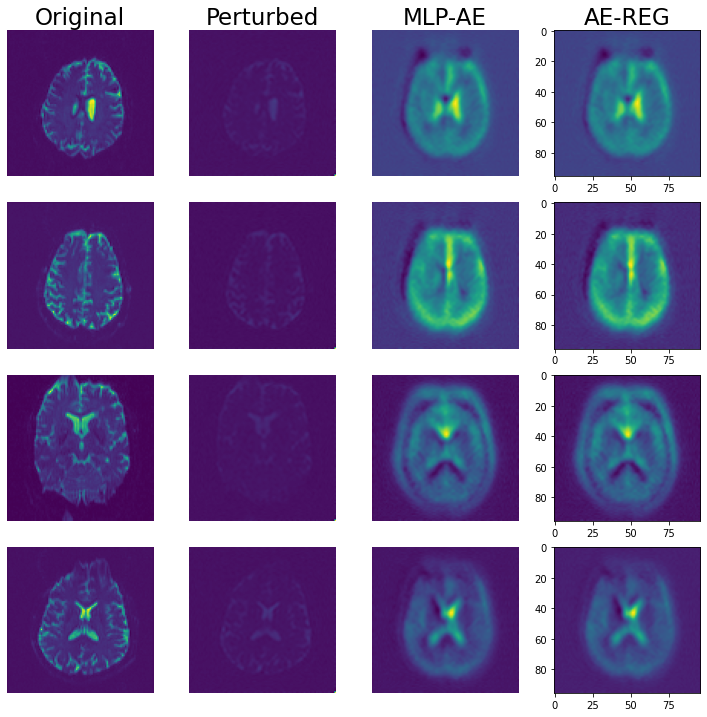

In [49]:
# PLotting images reconstructed from perturbed coefficients

fig, axes = plt.subplots(4, 4, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.imshow(trainImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(ImagesFromPerturbedTrainCoeffs[i][0])
    if(i==0):
        ax2.set_title('Perturbed', fontsize = 23)
    ax3.imshow(reconBase_train_perturbedCoeffs[i][0])
    if(i==0):
        ax3.set_title('MLP-AE', fontsize = 23)
    ax4.imshow(reconReg_train_perturbedCoeffs[i][0])
    if(i==0):
        ax4.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

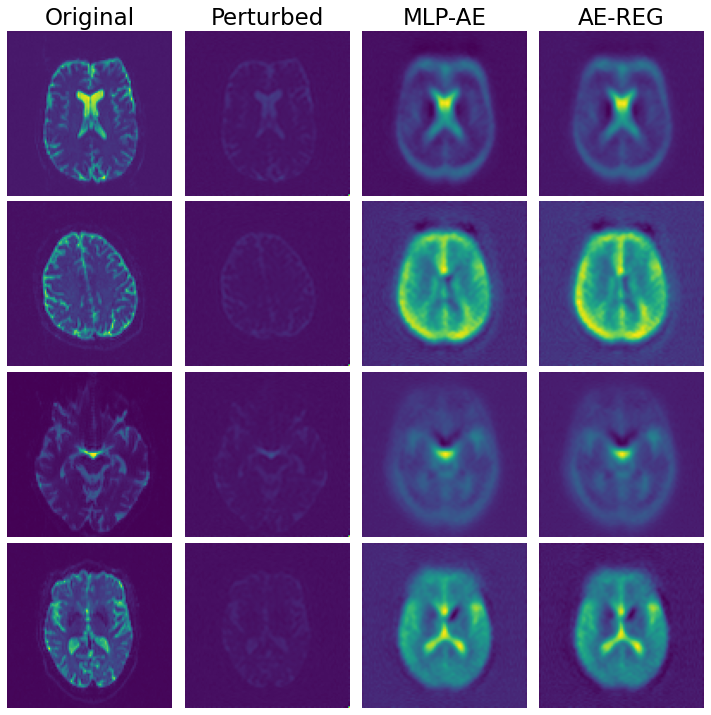

In [50]:
# PLotting images reconstructed from perturbed coefficients

fig, axes = plt.subplots(4, 4, figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
for i in range(4):
    ax1, ax2, ax3, ax4 = axes[i]
    ax1.imshow(testImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    if(i==0):
        ax1.set_title('Original', fontsize = 23)
    ax2.imshow(ImagesFromPerturbedTestCoeffs[i][0])
    if(i==0):
        ax2.set_title('Perturbed', fontsize = 23)
    ax3.imshow(reconBase_test_perturbedCoeffs[i][0])
    if(i==0):
        ax3.set_title('MLP-AE', fontsize = 23)
    ax4.imshow(reconReg_test_perturbedCoeffs[i][0])
    if(i==0):
        ax4.set_title('AE-REG', fontsize = 23)
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
plt.show()

In [51]:
# now get PSNR vs perturbation rate  plots

noise_order = torch.linspace(1e-3,100* 1e-3, 100)

#noise_order = torch.linspace(0.001,0.1, 100)

In [52]:
all_PSNR_bAE = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/PSNR_list_comparisons/all_PSNR_bAE_p01L18.pt')
all_PSNR_rAE = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/PSNR_list_comparisons/all_PSNR_rAE_p01L18.pt')


Text(0, 0.5, 'PSNR')

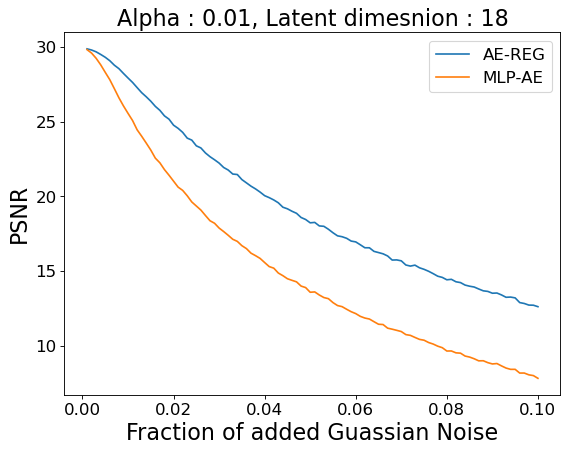

In [53]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(noise_order, all_PSNR_rAE, label = 'AE-REG')
plt.plot(noise_order, all_PSNR_bAE, label = 'MLP-AE')
plt.legend(loc=1, prop={'size': 15})
plt.title('Alpha : 0.01, Latent dimesnion : 18',fontsize=20)
plt.xticks(fontsize=15 ) 
plt.yticks(fontsize= 15) 
plt.xlabel('Fraction of added Guassian Noise',fontsize=20)
plt.ylabel('PSNR',fontsize=20)

Text(0, 0.5, 'PSNR')

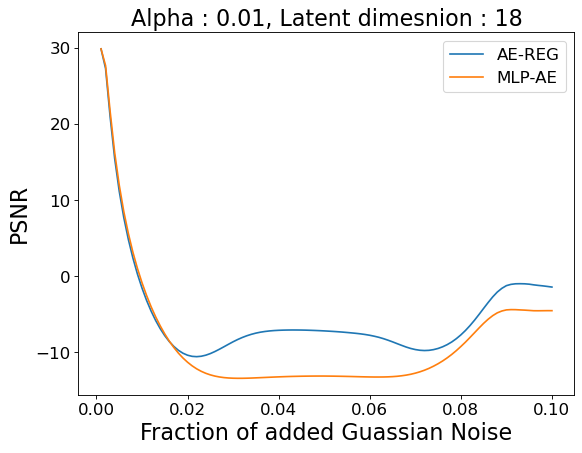

In [54]:
all_PSNR_bAE = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/PSNR_list_comparisons/HybridImgNoise_PSNR_bAE_p01L18.pt')
all_PSNR_rAE = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/PSNR_list_comparisons/HybridImgNoise_PSNR_rAE_p01L18.pt')


from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(noise_order, all_PSNR_rAE, label = 'AE-REG')
plt.plot(noise_order, all_PSNR_bAE, label = 'MLP-AE')
plt.legend(loc=1, prop={'size': 15})
plt.title('Alpha : 0.01, Latent dimesnion : 18',fontsize=20)
plt.xticks(fontsize=15 ) 
plt.yticks(fontsize= 15) 
plt.xlabel('Fraction of added Guassian Noise',fontsize=20)
plt.ylabel('PSNR',fontsize=20)